In [32]:
# ! pip install learn2learn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import learn2learn as l2l
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import copy
import os

(CVXPY) Apr 15 08:48:05 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')
(CVXPY) Apr 15 08:48:05 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')


In [31]:
! pip install learn2learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.8 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.0/299.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 90.3 MB/s eta 0:

In [4]:
training_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("USING DEVICE:", training_device)

USING DEVICE: cuda


In [5]:
df_train = pd.read_csv("/kaggle/input/assignment-2milestone-2/df_train_shuffled.csv")
df_val = pd.read_csv("/kaggle/input/assignment-2milestone-2/df_val.csv")
df_test = pd.read_csv("/kaggle/input/assignment-2milestone-2/df_val_test.csv")

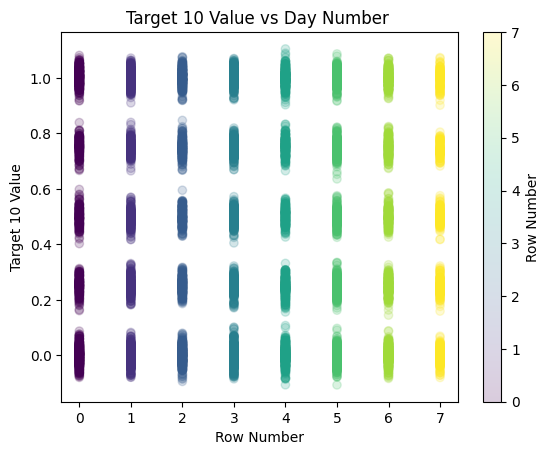

In [6]:
df_train_copy = pd.read_csv("/kaggle/input/assignment-2milestone-2/df_train_shuffled.csv")
df_train_copy = df_train_copy.sort_values(by=["row_num"])
df_train_copy.head()
row_num = df_train_copy["row_num"][:10000].values
target_10_vals = df_train_copy["target_10_val"][:10000].values
for i in range(10000):
    target_10_vals[i] = target_10_vals[i] + np.random.normal(0, 0.03)
    
plt.scatter(row_num, target_10_vals, c= row_num,alpha = 0.2, cmap='viridis')
plt.xlabel("Row Number")
plt.ylabel("Target 10 Value")
plt.title("Target 10 Value vs Day Number ")
plt.colorbar().set_label("Row Number")

# corr = df_train_copy.corr(method = 'pearson')
# sns.heatmap(corr,cmap='coolwarm')

In [7]:
unique_labels = df_train["target_10_val"].unique()
unique_labels.sort()

# Create a dictionary to map labels to integers
label_to_int = {label: i for i, label in enumerate(unique_labels)}

# Apply the label encoding using the dictionary
df_train["target_10_val"] = df_train["target_10_val"].map(label_to_int)
df_val["target_10_val"] = df_val["target_10_val"].map(label_to_int)
df_test["target_10_val"] = df_test["target_10_val"].map(label_to_int)

In [8]:
label_to_int

{0.0: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1.0: 4}

In [9]:
df_train.head()

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,High_n-Low_n_changelen_val,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,era,target_10_val,target_5_val
0,0.75,0.75,0.75,0.75,0.25,1.00,1.00,0.50,0.25,0.25,...,0.75,0.25,0.50,0.75,1.00,0.50,100,220,3,0.50
1,0.25,0.25,0.25,0.25,0.25,0.50,0.75,0.00,0.25,1.00,...,0.00,0.50,1.00,1.00,0.75,0.75,24,11,2,0.25
2,0.75,0.75,0.75,0.50,0.50,0.50,0.25,1.00,0.75,1.00,...,0.50,0.50,0.25,0.50,0.50,0.50,83,115,2,0.50
3,0.25,0.25,0.25,0.25,0.75,0.25,0.25,0.75,0.50,0.00,...,0.50,0.25,0.25,1.00,0.75,1.00,101,207,4,0.75
4,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.25,0.50,1.00,...,0.75,0.50,0.00,0.00,0.50,0.50,101,178,2,0.50


In [10]:
class M2Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, target, drop):
        self.dataframe = dataframe
        self.labels = self.dataframe[target].values
        self.data = self.dataframe.drop(drop, axis = 1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data.iloc[idx].values, self.labels[idx]

In [11]:
class M2LiveDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, drop = None, type = 'train'):
        self.dataframe = dataframe
        self.type = type
        if type == 'train':
            self.labels = dataframe["target_10_val"].values
            self.data = dataframe.drop(drop, axis = 1).values
        elif self.type == 'test':
            self.ids = dataframe["id"].values
            self.row_num = dataframe["row_num"].values
            self.data = dataframe.drop(drop, axis = 1).values
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.type == 'train':
            
            return np.array(self.data[idx], np.float64), self.labels[idx]
        elif self.type == 'test':
            return np.array(self.data[idx], np.float64), self.ids[idx], self.row_num[idx]

In [12]:
drop = ['row_num','era','target_10_val','target_5_val']
train_dataset = M2Dataset(df_train, 'target_10_val', drop)
val_dataset = M2Dataset(df_val, 'target_10_val', drop)
test_dataset = M2Dataset(df_test, 'target_10_val', drop)

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 4096, shuffle = False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 4096, shuffle = False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4096, shuffle = False)

In [15]:
drop_train = ['row_num','era','id','target_10','target_5','target_10_val','target_5_val']
drop_test = ['id', 'row_num']
day_datasets = {}
train_cols = []
test_cols = []
base = '/kaggle/input/aml-a2-m2-livedata/LiveData'
for dir in os.listdir(base):
    train_data = np.empty((0, 31))
    test_data = np.empty((0, 26))
    date = dir
    for file in os.listdir(os.path.join(base,dir)):
        file_path = os.path.join(base,dir,file)
        df = pd.read_csv(file_path)
        if 'train' in file:
            df["target_10_val"] = df["target_10_val"].map(label_to_int)
            if (len(train_cols) == 0):
                train_cols = df.columns
                train_col_types = df.dtypes
            train_data = np.vstack((train_data, df.to_numpy()))
        else:
            if (len(test_cols) == 0):
                test_cols = df.columns
                test_col_types = df.dtypes
            test_data = np.vstack((test_data,df.to_numpy()))
        
    train_df = pd.DataFrame(train_data, columns = train_cols)
    test_df = pd.DataFrame(test_data, columns = test_cols)
    train_dataset = M2LiveDataset(train_df, drop = drop_train, type = "train")
    test_dataset = M2LiveDataset(test_df, drop = drop_test, type = "test")
    day_datasets[date] = (train_dataset, test_dataset)

In [16]:
class CustomLoss(torch.nn.Module):
    def __init__(self, reg, no_of_class):
        super(CustomLoss, self).__init__()
        self.reg = reg
        self.no_of_class = no_of_class

    def forward(self, inputs, targets):
        p = torch.Tensor(inputs[0]).to(training_device).t()

        targets = torch.eye(self.no_of_class).to(training_device)[targets].t()
        tou = torch.Tensor(inputs[1]).to(training_device)
        tou = tou.t()

        loss_a = torch.t(targets) @ torch.log(tou * (p - targets) + targets)
        loss_b = self.reg * torch.log(tou)
        loss_a = loss_a.diag().t()
        
        loss = loss_a + loss_b
        return -loss.mean()

    def custom_p(p):
        return p

In [17]:
class TestTimeModelMLP(torch.nn.Module):
    def __init__(
        self,
        input_size,
        classification_output_size,
        shared_layers,
        classification_layers,
        auxiliary_layers,
    ):
        super(TestTimeModelMLP, self).__init__()
        self.input_size = input_size
        shared = []
        for i in range(len(shared_layers)):
            if i == 0:
                shared.append(torch.nn.Linear(input_size, shared_layers[i]))
                shared.append(torch.nn.ReLU())
                shared.append(torch.nn.LayerNorm([shared_layers[i]]))
            elif i < len(shared_layers) - 1:
                shared.append(torch.nn.Linear(shared_layers[i - 1], shared_layers[i]))
                shared.append(torch.nn.ReLU())
                shared.append(torch.nn.LayerNorm([shared_layers[i]]))
            else:
                shared.append(torch.nn.Linear(shared_layers[i - 1], shared_layers[i]))
                shared.append(torch.nn.ReLU())
                

        self.shared_layers = torch.nn.Sequential(*shared)

        classification = []
        for i in range(len(classification_layers)):
            if i == 0 and len(classification_layers) == 1:
                classification.append(torch.nn.Linear(shared_layers[-1], classification_output_size))
            elif i == 0:
                classification.append(
                    torch.nn.Linear(shared_layers[-1], classification_layers[i])
                )
                classification.append(torch.nn.ReLU())
                classification.append(torch.nn.LayerNorm(classification_layers[i]))
            elif i < len(classification_layers) - 1:
                classification.append(
                    torch.nn.Linear(
                        classification_layers[i - 1], classification_layers[i]
                    )
                )
                classification.append(torch.nn.ReLU())
                classification.append(torch.nn.LayerNorm(classification_layers[i]))
            else:
                classification.append(
                    torch.nn.Linear(classification_layers[i - 1], classification_output_size)
                )

        self.classification_layers = torch.nn.Sequential(*classification)

        auxiliary = []
        for i in range(len(auxiliary_layers)):
            if i == 0 and len(auxiliary_layers) == 1:
                auxiliary.append(torch.nn.Linear(shared_layers[-1], self.input_size))
            elif i == 0:
                auxiliary.append(
                    torch.nn.Linear(shared_layers[-1], auxiliary_layers[i])
                )
                auxiliary.append(torch.nn.ReLU())
                auxiliary.append(torch.nn.LayerNorm(auxiliary_layers[i]))
            elif i < len(auxiliary_layers) - 1:
                auxiliary.append(
                    torch.nn.Linear(auxiliary_layers[i - 1], auxiliary_layers[i])
                )
                auxiliary.append(torch.nn.ReLU())
                auxiliary.append(torch.nn.LayerNorm(auxiliary_layers[i]))
            else:
                auxiliary.append(
                    torch.nn.Linear(auxiliary_layers[i - 1], self.input_size)
                )

        self.auxiliary_layers = torch.nn.Sequential(*auxiliary)

    def forward(self, x):
        shared_out = self.shared_layers(x)
        classification_out = self.classification_layers(shared_out)
        auxiliary_out = self.auxiliary_layers(shared_out)
        return classification_out, auxiliary_out

In [18]:
class TestTimeModelMLP_NAL(torch.nn.Module):
    def __init__(
        self,
        input_size,
        classification_output_size,
        shared_layers,
        classification_layers,
        auxiliary_layers,
    ):
        super(TestTimeModelMLP_NAL, self).__init__()
        self.input_size = input_size
        shared = []
        for i in range(len(shared_layers)):
            if i == 0:
                shared.append(torch.nn.Linear(input_size, shared_layers[i]))
                shared.append(torch.nn.ReLU())
            elif i < len(shared_layers) - 1:
                shared.append(torch.nn.Linear(shared_layers[i - 1], shared_layers[i]))
                shared.append(torch.nn.ReLU())
            else:
                shared.append(torch.nn.Linear(shared_layers[i - 1], shared_layers[i]))
                shared.append(torch.nn.ReLU())
                shared.append(torch.nn.LayerNorm([shared_layers[i]]))

        self.shared_layers = torch.nn.Sequential(*shared)

        classification = []
        for i in range(len(classification_layers)):
            if i == 0 and len(classification_layers) == 1:
                classification.append(torch.nn.Linear(shared_layers[-1], classification_output_size))
            elif i == 0:
                classification.append(
                    torch.nn.Linear(shared_layers[-1], classification_layers[i])
                )
                classification.append(torch.nn.ReLU())
            elif i < len(classification_layers)-1:
                classification.append(
                    torch.nn.Linear(
                        classification_layers[i - 1], classification_layers[i]
                    )
                )
                classification.append(torch.nn.ReLU())
                classification.append(torch.nn.LayerNorm(classification_layers[i]))
            else:
                classification.append(
                    torch.nn.Linear(
                        classification_layers[i - 1], classification_layers[i]
                    )
                )
                
        
        self.attention_layer = torch.nn.Linear(classification_layers[-1], 1) 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()
        self.classification_head = torch.nn.Linear(classification_layers[-1], classification_output_size)

        self.classification_layers = torch.nn.Sequential(*classification)

        auxiliary = []
        for i in range(len(auxiliary_layers)):
            if i == 0 and len(auxiliary_layers) == 1:
                auxiliary.append(torch.nn.Linear(shared_layers[-1], self.input_size))
            elif i == 0:
                auxiliary.append(
                    torch.nn.Linear(shared_layers[-1], auxiliary_layers[i])
                )
                auxiliary.append(torch.nn.ReLU())
            elif i < len(auxiliary_layers) - 1:
                auxiliary.append(
                    torch.nn.Linear(auxiliary_layers[i - 1], auxiliary_layers[i])
                )
                auxiliary.append(torch.nn.ReLU())
                auxiliary.append(torch.nn.LayerNorm(auxiliary_layers[i]))
            else:
                auxiliary.append(
                    torch.nn.Linear(auxiliary_layers[i - 1], self.input_size)
                )

        self.auxiliary_layers = torch.nn.Sequential(*auxiliary)

    def forward(self, x):
        shared_out = self.shared_layers(x)
        classification_out = self.classification_layers(shared_out)
        attention_output = self.attention_layer(classification_out)
        attention_output = self.sigmoid(attention_output)
        classification_out = self.classification_head(classification_out)
        classification_out = self.softmax(classification_out)
        auxiliary_out = self.auxiliary_layers(shared_out)
        return classification_out,attention_output, auxiliary_out

In [19]:
def train (model,dataloader,optimizer, criterion_classifcation, criterion_auxiliary, epochs = 10):
    model.train()
    train_loss = []
    train_time_accuracies = []
    for epoch in range(epochs):
        epoch_loss_list = []
        epoch_preds = []
        epoch_labels = []
        for data,label in tqdm(dataloader):
            data, label = data.to(training_device).float(), label.to(training_device).long()
            optimizer.zero_grad()
            classification_out, auxiliary_out = model(data)
            loss = criterion_classifcation(classification_out, label)
            loss += criterion_auxiliary(auxiliary_out, data)
            train_loss.append(loss.item())
            batch_loss = loss.item()
            epoch_loss_list.append(batch_loss)
            pred = classification_out.argmax(dim = 1)
            epoch_labels.append(label)
            epoch_preds.append(pred)
            loss.backward()
            optimizer.step()
            
        train_loss.append(np.mean(epoch_loss_list))
        train_time_accuracies.append(accuracy_score(torch.cat(epoch_labels).cpu().numpy(), torch.cat(epoch_preds).cpu().numpy()))        
        print(f"Epoch {epoch} : Loss {train_loss[-1]} Accuracy {train_time_accuracies[-1]}")

        
    return train_loss, train_time_accuracies

In [20]:
def train_noise (model,dataloader,optimizer, criterion_classifcation, criterion_auxiliary, epochs = 10, spacing = 100):
    train_loss = []
    test_time_accuracies = []
    for epoch in range(epochs):
        epoch_loss_list = []
        epoch_preds = []
        epoch_labels = []
        model.train()
        for data,label in tqdm(dataloader):
            data, label = data.to(training_device).float(), label.to(training_device).long()
            optimizer.zero_grad()
            classification_out,attention_out, auxiliary_out = model(data)
            loss = criterion_classifcation([classification_out,attention_out], label)
            loss += criterion_auxiliary(auxiliary_out, data)
            pred = classification_out.argmax(dim = 1)
            epoch_labels.append(label)
            epoch_preds.append(pred)
            train_loss.append(loss.item())
            batch_loss = loss.item()
            epoch_loss_list.append(batch_loss)
            loss.backward()
            optimizer.step()
            

        
        train_loss.append(np.mean(epoch_loss_list))
        test_time_accuracies.append(accuracy_score(torch.cat(epoch_labels).cpu().numpy(), torch.cat(epoch_preds).cpu().numpy()))        
        print(f"Epoch {epoch} : Loss {train_loss[-1]} Accuracy {test_time_accuracies[-1]}")

        
    return train_loss, test_time_accuracies
            
        

In [21]:
model = TestTimeModelMLP_NAL(input_size=24, classification_output_size=5, shared_layers=[64, 64], classification_layers=[64,48], auxiliary_layers=[64,48])
model = model.to(training_device)
model

TestTimeModelMLP_NAL(
  (shared_layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (attention_layer): Linear(in_features=48, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
  (classification_head): Linear(in_features=48, out_features=5, bias=True)
  (classification_layers): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
  )
  (auxiliary_layers): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24, bias=True)
  )
)

In [ ]:
# classification_criterion = torch.nn.CrossEntropyLoss()
# auxiliary_criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# train_loss, train_time_accuracies = train(model, train_dataloader, optimizer,classification_criterion,auxiliary_criterion, epochs = 200)

In [22]:
classification_criterion = CustomLoss(3,5)
auxiliary_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, train_time_accuracies = train_noise(model, val_dataloader, optimizer,classification_criterion,auxiliary_criterion, epochs = 20)

  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


Epoch 0 : Loss 2.1632413222239566 Accuracy 0.28738604152302155


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Epoch 1 : Loss 1.6467783817878137 Accuracy 0.29633034551444115


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.12it/s]


Epoch 2 : Loss 1.615420515720661 Accuracy 0.26735233279705817


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.58it/s]


Epoch 3 : Loss 1.5868249764809241 Accuracy 0.2967325519037769


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


Epoch 4 : Loss 1.5695378046769362 Accuracy 0.29883934727648814


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.33it/s]


Epoch 5 : Loss 1.5516230693230262 Accuracy 0.3007354631119283


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.11it/s]


Epoch 6 : Loss 1.5358200531739454 Accuracy 0.30481498506090554


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


Epoch 7 : Loss 1.5234092198885405 Accuracy 0.3105033325672259


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.56it/s]


Epoch 8 : Loss 1.5149462039654071 Accuracy 0.31148011951275567


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.58it/s]


Epoch 9 : Loss 1.508932269536532 Accuracy 0.3119972420133303


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.15it/s]


Epoch 10 : Loss 1.5042476837451642 Accuracy 0.31465946525702904


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.61it/s]


Epoch 11 : Loss 1.5004726006434514 Accuracy 0.31657473377767564


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Epoch 12 : Loss 1.4969452619552612 Accuracy 0.3182218647054317


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Epoch 13 : Loss 1.4936152146412776 Accuracy 0.31971577415153607


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.08it/s]


Epoch 14 : Loss 1.490902854846074 Accuracy 0.32078832452309813


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Epoch 15 : Loss 1.4887753908450787 Accuracy 0.3209798513751628


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


Epoch 16 : Loss 1.487126772220318 Accuracy 0.3212862943384662


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.01it/s]


Epoch 17 : Loss 1.4856888514298658 Accuracy 0.3211330728568145


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch 18 : Loss 1.4844206479879527 Accuracy 0.32161188998697615


  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 13/13 [00:02<00:00,  5.51it/s]

Epoch 19 : Loss 1.483189271046565 Accuracy 0.3214969738757374


In [23]:
PATH="/kaggle/working/cl_tta_pretrained_model.pt"
torch.save(model,PATH)

In [24]:
def MAML(train_dataloader,model,epochs=1):
    model.train()
    maml = l2l.algorithms.MAML(model, lr=0.1)
    optimizer = torch.optim.Adam(maml.parameters(), lr=0.001)
    epoch_loss_list = []
    epoch_preds = []
    epoch_labels = []
    initial_weights = maml.state_dict()
    
    # Check Model Accuracy Before Adaptation
    model.eval()
    for data,label in tqdm(train_dataloader):
        data, label = data.to(training_device).float(), label.to(training_device).long()
        classification_out,attention_out, auxiliary_out = model(data)
        pred = classification_out.argmax(dim = 1)
        epoch_labels.append(label)
        epoch_preds.append(pred)
    acc_score=accuracy_score(torch.cat(epoch_labels).cpu().numpy(), torch.cat(epoch_preds).cpu().numpy())
    print("ACCURACY WITHOUT ADAPTATION:",acc_score)

    #Updating Meta Models Weight
    model.train()
    for epoch in tqdm(range(epochs)):
        for data,label in train_dataloader:
            task_model = maml.clone()
            data, label = data.to(training_device).float(), label.to(training_device).long()
            optimizer.zero_grad()
            classification_out,attention_out, auxiliary_out = task_model(data)
            loss = classification_criterion([classification_out,attention_out], label)
            loss += auxiliary_criterion(auxiliary_out, data)
            task_model.adapt(loss)
            eval_loss = classification_criterion([classification_out,attention_out], label)
            eval_loss += auxiliary_criterion(auxiliary_out, data)
            pred = classification_out.argmax(dim = 1)
            eval_loss.backward()
            optimizer.step()
    
    # After Updation Check Accuracy on Train
    model.eval()
    epoch_loss_list = []
    epoch_preds = []
    epoch_labels = []   
    for data,label in tqdm(train_dataloader):
            data, label = data.to(training_device).float(), label.to(training_device).long()
            classification_out,attention_out, auxiliary_out = model(data)
            pred = classification_out.argmax(dim = 1)
            epoch_labels.append(label)
            epoch_preds.append(pred)
    acc_score=accuracy_score(torch.cat(epoch_labels).cpu().numpy(), torch.cat(epoch_preds).cpu().numpy())
    print("Accuracy of final Model:",acc_score)
    return model

In [26]:
day_datasets.keys()

dict_keys(['04-04-2024', '03-04-2024', '05-04-2024', '08-04-2024', '21-03-2024', '09-04-2024', '02-04-2024', '10-04-2024', '12-04-2024', '28-03-2024'])

In [43]:
def generate_csv(day,model,round_no,test_loader):
    model.eval()
    predictions = []
    class_mapping={0:0,1:0.25,2:0.5,3:0.75,4:1}
    for data,ids,row_no in tqdm(test_loader):
        data=data.to(training_device).float()
        classification_out,_,_ = model(data)
        pred = classification_out.argmax(dim = 1)
        converted_pred=[class_mapping[p.item()] for p in pred]
        for i in range(len(ids)):
            predictions.append([ids[i], converted_pred[i],row_no[i].item(),round_no])
    df = pd.DataFrame(predictions, columns=["id","prediction","row_num","round_no"])
    csv_filename = "predictions_" + day + ".csv"
    df.to_csv(csv_filename,index=False)
    return 

In [28]:
def train_and_generate(model,list_of_days):
    round_no=0
    for day in list_of_days:
        round_no+=1
        train_daily=day_datasets[day][0]
        test_daily=day_datasets[day][1]
        daily_train_dataloader = torch.utils.data.DataLoader(train_daily, batch_size = 4096, shuffle = False)
        daily_test_dataloader = torch.utils.data.DataLoader(test_daily, batch_size = 4096, shuffle = False)
        model.train()
        model=MAML(daily_train_dataloader,model,epochs=100)
        generate_csv(day,model,round_no,daily_test_dataloader)
    return

In [296]:
day='04-04-2024'
train_daily=day_datasets[day][0]
test_daily=day_datasets[day][1]
daily_train_dataloader = torch.utils.data.DataLoader(train_daily, batch_size = 4096, shuffle = False)
daily_test_dataloader = torch.utils.data.DataLoader(test_daily, batch_size = 4096, shuffle = False)
model = torch.load(PATH)

In [298]:
model=torch.load(PATH)
model=MAML(test_dataloader,model,epochs=50)

  0%|          | 0/14 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 14/14 [00:02<00:00,  6.51it/s]


ACCURACY WITHOUT ADAPTATION: 0.31150311608746173


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 14/14 [00:02<00:00,  6.00it/s]

Accuracy of final Model: 0.3311855216365621


In [44]:
model = torch.load(PATH)
list_of_days=["02-04-2024","03-04-2024","04-04-2024","05-04-2024"]
train_and_generate(model,list_of_days)


100%|██████████| 4/4 [00:00<00:00, 29.52it/s]


ACCURACY WITHOUT ADAPTATION: 0.34069351578292645


  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 4/4 [00:00<00:00, 29.64it/s]


Accuracy of final Model: 0.8919297154408334


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 2/2 [00:00<00:00, 24.20it/s]


ACCURACY WITHOUT ADAPTATION: 0.25937459452445827


  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 2/2 [00:00<00:00, 24.96it/s]


Accuracy of final Model: 0.8792007266121707


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 4/4 [00:00<00:00, 28.43it/s]


ACCURACY WITHOUT ADAPTATION: 0.25355047854276014


  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 4/4 [00:00<00:00, 11.25it/s]


Accuracy of final Model: 0.9140166718122877


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 4/4 [00:00<00:00, 24.39it/s]


ACCURACY WITHOUT ADAPTATION: 0.258310777985981


  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 4/4 [00:00<00:00, 26.32it/s]


Accuracy of final Model: 0.8790339371226317


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 1/1 [00:00<00:00, 114.12it/s]
